# Lesson 5a: Recurrent Neural Networks: Sequence Prediction

**This week's homework has two different parts: rnn_sine and rnn_divisibility. Be sure to do both!**

Each part focuses on a different type of Recurrent Neural Network architecture: prediction or classification

* 5a) **rnn_sine** (this file): Prediction of the next time point given the previous time history
* 5b) **rnn_divisibility**: Categorization of an input string

In this homework, you will create a *synthetic* dataset based on some simple mathematical functions. Then, you will design an RNN architecture that can read several function values in a row (*e.g.*, the values of the function at time points 0, 1, 2, 3, 4) and predict the next value (*e.g.*, the value of the function at time point 5).

In [12]:
%matplotlib inline

from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.regularizers import l1_l2
import math
import numpy as np
import matplotlib.pyplot as plt

## source:

- [LSTM Neural Network for Time Series Prediction](https://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction)

# Settings

In [2]:
NUM_LSTM_NODES = 15
NUM_EPOCHS = 10


#Set up params for dataset.
NUM_FREQS = 2      # Number of sine waves to superimpose
SR = 200           # Digital sampling rate
MAX_FREQ = SR / 2  # Nyquist frequency
two_pi = 2 * math.pi

MAX_FREQ /= 4  # calm the frequencies down a little.

MAX_X_DATA = 5     # Set x-range from 0 to MAX_X_DATA

TRAIN_TEST_SPLIT = 0.7  # Percentage of data in training set

# Use this to try on random sine waves if you'd like.
RANDOMIZE_WAVES = False
if RANDOMIZE_WAVES:
    np.random.seed(42)
    freqs = np.random.rand(NUM_FREQS) * MAX_FREQ
    amplitudes = np.random.rand(NUM_FREQS)
    phases = np.random.rand(NUM_FREQS) * two_pi
    waves = list(zip(freqs, amplitudes, phases))
else:
    # Or just use fixed frequencies etc, to make it easier:
    waves = [(20, .5, 0), (3, .3, 3)]  # Each element is (freq, amplitude, phase)
waves

[(20, 0.5, 0), (3, 0.3, 3)]

In [3]:
# Make the sine wave data.
data = []
t_list = [float(i)/SR for i in range(SR * MAX_X_DATA)]
for t in t_list:
    total = 0
    for freq, A, phase in waves:
        total += A * np.sin(phase + t * freq * two_pi)
    data.append(total)

# normalize
max_data = abs(np.max(data))
data /= max_data

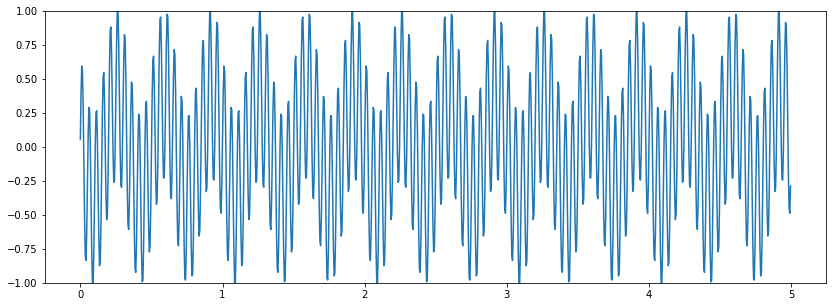

In [4]:
plt.figure(figsize=(14,5))
plt.ylim(-1,1)
plt.plot(t_list, data)
plt.show()

In [5]:
# Make input/ouput pairs: match datapoint (N) to each datapoint (N+1)
# data_pairs should be a list of data points like [(data_1, data_2), (data_2, data_3),...]
data_pairs = [(x, y) for x, y in zip(t_list, data)]

In [6]:
split_idx = int(len(data_pairs)*TRAIN_TEST_SPLIT )
train = data_pairs[:split_idx]
test = data_pairs[split_idx:]

train_x = np.array([x[0] for x in train])
train_y = np.array([x[1] for x in train])
train_x = np.reshape(train_x, (len(train_x), 1, 1))  # batch, #prev_context, #input nodes
train_y = np.reshape(train_y, (len(train_y), 1))     # batch, #prev_context, #output nodes

test_x = np.array([x[0] for x in test])
test_y = np.array([x[1] for x in test])
test_x = np.reshape(test_x, (len(test_x), 1, 1))  # batch, #prev_context, #input nodes
test_y = np.reshape(test_y, (len(test_y), 1))     # batch, #prev_context, #output nodes

In [7]:
# Build LSTM model.

# Just an example. TODO: modify to improve performance:

model = Sequential()
model.add(LSTM(NUM_LSTM_NODES, batch_input_shape=(1, 1, 1), stateful=True))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

# compile model
model.compile(loss='mse', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 15)                   1020      
_________________________________________________________________
dense_1 (Dense)              (1, 5)                    80        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    6         
Total params: 1,106
Trainable params: 1,106
Non-trainable params: 0
_________________________________________________________________


In [13]:
layers =  [1, 50, 100, 1]
model = Sequential()

model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(layers[2], return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=layers[3]))
model.add(Activation("linear"))

model.summary()
model.compile(loss="mse", optimizer="rmsprop")

/Users/guillaumethomas/.virtualenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
/Users/guillaumethomas/.virtualenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


/Users/guillaumethomas/.virtualenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  # Remove the CWD from sys.path while we load stuff.


In [14]:
# fit model
for i in range(NUM_EPOCHS):
    print("Epoch %d" % i)
    model.fit(train_x, train_y, batch_size=1, epochs=1, shuffle=False, verbose=1)
    model.reset_states()

Epoch 0
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
700/700 [==============================] - 3s 5ms/step - loss: 0.2844
Epoch 1
Epoch 1/1
700/700 [==============================] - 2s 3ms/step - loss: 0.2836
Epoch 2
Epoch 1/1
700/700 [==============================] - 2s 3ms/step - loss: 0.2828
Epoch 3
Epoch 1/1
700/700 [==============================] - 2s 3ms/step - loss: 0.2832
Epoch 4
Epoch 1/1
700/700 [==============================] - 2s 3ms/step - loss: 0.2816
Epoch 5
Epoch 1/1
700/700 [==============================] - 2s 3ms/step - loss: 0.2780
Epoch 6
Epoch 1/1
700/700 [==============================] - 2s 3ms/step - loss: 0.2800
Epoch 7
Epoch 1/1
700/700 [==============================] - 2s 3ms/step - loss: 0.2789
Epoch 8
Epoch 1/1
700/700 [==============================] - 2s 3ms/step - loss: 0.2857
Epoch 9
Epoch 1/1
700/700 [==============================] - 2s 3ms/step - loss: 0.2821


In [15]:
# Evaluate accuracy
scores = model.evaluate(test_x, test_y, batch_size=1, verbose=0)
model.reset_states()
print("Model Accuracy: %.2f%%" % (scores*100))

Model Accuracy: 47.28%


## Make predictions with the model

In [16]:
result = []
for i in range(len(test_x)):
    prediction = model.predict(test_x[i].reshape(1,1,1), verbose=0)
    result.append([prediction, test_y[i]])
model.reset_states()  # Do this after giving an input sequence, to clear out hidden states.

In [17]:
predictions = [[x[0][0][0], x[1][0]] for x in result]

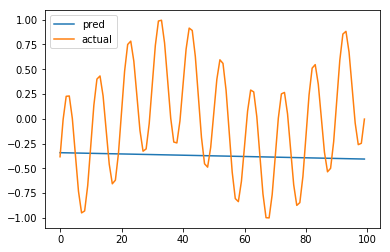

In [18]:
plt.plot(predictions[50:150])
plt.legend(('pred', 'actual'))
plt.show()

In [19]:
errors = [abs(x[1] - x[0]) for x in predictions]

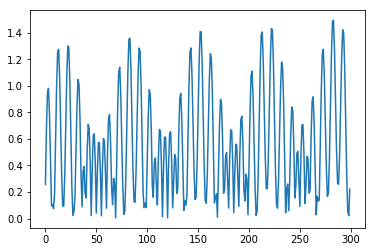

In [20]:
plt.plot(errors)
plt.show()

## Question 1: Discuss the results. How accurate was the model? What did you do to improve its accuracy? What problems did you run into?

In [ ]:
TODO

## Question 2: What problems did you run into, if any?

In [ ]:
TODO